<a href="https://colab.research.google.com/github/dnhshl/hyperparameter_doe/blob/main/simpleRobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.





## Lade notwendige Libraries


In [63]:
!pip install keras_sequential_ascii

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import optimizers


from keras_sequential_ascii import keras2ascii

from google.colab import files
import time
import csv



# Hyperparameter

In [45]:

# NN Structure Parameter

layer1size = 100
layer2size = 100
layer3size = 100

# Training Parameter

tdatasize = 10000
myoptimizer = optimizers.Adam
learning_rate = 1E-2
batch_size = 32
epochs = 10

# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `phi1` und `phi2` die `x` und `y` Position berechnet werden kann. 

Der Einfachheit halber (um auszuschließen, dass gleiche Positionen mit unterschiedlichen Winkelstellungen angefahren werden können) wird `phi1` auf 0 .. 90 Grad und `phi2` auf -90 .. 0 Grad eingeschränkt.

In [46]:



def gen_data(size):

  l1 = 1  # Länge des ersten Roboterarms
  l2 = 1  # Länge des zweiten Roboterarms

  # phi1 im Bereich von 0 .. 90 Grad 
  phi1 = np.random.random_sample(size) * np.pi/2 

  # phi2 im Bereich von 0 .. -90 Grad 
  phi2 = -np.random.random_sample(size) * np.pi/2

  # Kombiniere Vektoren als Matrix
  dout = np.vstack((phi1, phi2)).T

  # Berechne x und y
  din = np.array([l1 * np.cos(dout[:,0]) + l2 * np.cos(dout.sum(axis=1)), 
                  l1 * np.sin(dout[:,0]) + l2 * np.sin(dout.sum(axis=1))]).T 

  return (din, dout)



# Trainingsdaten


In [47]:
(din, dout) = gen_data(tdatasize)


# NN

Zwei Fully Connected Layer, der erste Layer mit Aktivierungsfunktion.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Sie können auch [andere Loss Functions](https://keras.io/api/losses/) ausprobieren.

Testen Sie auch verschiedene [Optimizer](https://keras.io/api/optimizers/) .

## Hyperparameter

## Konstruiere NN

In [49]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(layer1size, input_shape=[2,], activation='tanh'),
      layers.Dense(layer2size, activation='tanh'),
      layers.Dense(layer3size, activation='tanh'),
      layers.Dense(2)     ## output
  ])

  model.compile(loss='mean_squared_error',
                optimizer=myoptimizer(learning_rate=learning_rate))
  return model

In [50]:
mymodel = build_and_compile_model()
mymodel.summary()

print()
print('________________________')
print('NN Struktur in Ascii Art')
print('________________________')
print()

keras2ascii(mymodel)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 202       
Total params: 20,702
Trainable params: 20,702
Non-trainable params: 0
_________________________________________________________________

________________________
NN Struktur in Ascii Art
________________________

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           2
               Dense   XXXXX -------------------       3

## Trainiere Modell

Nutze 20% der Testdaten als Validierungsdatensatz

In [51]:


history = mymodel.fit(din, dout,
          batch_size=batch_size, epochs=epochs,
          validation_split = 0.2)

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3199 - val_loss: 0.0173
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0101
Epoch 3/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0069
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 5/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0088
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 8/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 9/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 10/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0015

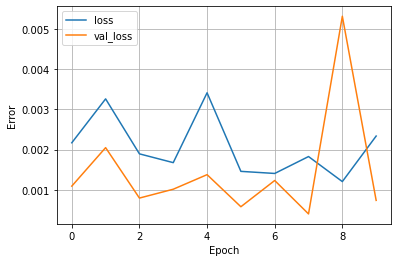

In [37]:


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Teste trainiertes Modell

In [57]:
testdatasize = 100

(testdata_in, testdata_out) = gen_data(testdatasize)

predictions = mymodel.predict(testdata_in)


for i in range(10):
  print(predictions[i], testdata_out[i])


testdataloss = mymodel.evaluate(testdata_in, testdata_out, batch_size = testdatasize, verbose=1)
print('testdataloss:', testdataloss)


[ 0.8332556  -0.17223728] [ 0.81675896 -0.11798496]
[ 1.0662755 -1.3099964] [ 1.07538728 -1.31950513]
[ 0.39818418 -1.0455627 ] [ 0.41018217 -1.07079042]
[ 0.7801032  -0.68836015] [ 0.7845802  -0.69195135]
[ 0.4623326 -1.491837 ] [ 0.48546135 -1.53813625]
[ 0.26398712 -0.14482486] [ 0.19724318 -0.00898034]
[ 0.3320376 -1.4642518] [ 0.3575661  -1.51113814]
[ 0.9290441  -0.14507933] [ 0.91130881 -0.08278049]
[ 0.20814289 -0.71487755] [ 0.23313789 -0.77602908]
[ 0.57069176 -0.8519639 ] [ 0.56842277 -0.85768376]
1/1 [==============================] - 0s 15ms/step - loss: 0.0021
testdataloss: 0.0020995107479393482


## Teste verschiedene Trajektorien

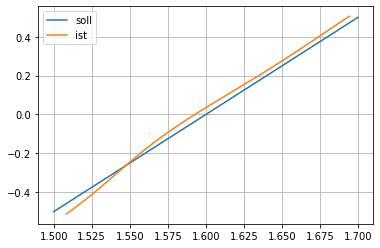

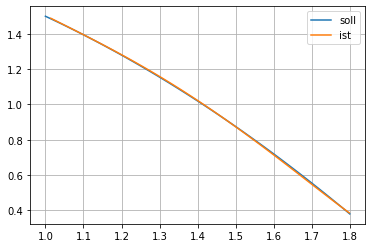

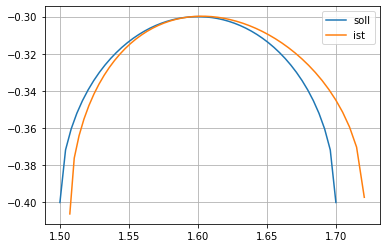

In [53]:
# Gerade
xtest1 = np.linspace(1.5,1.7)
ytest1 = 1/0.2*(xtest-1.5) -0.5

# Parabel
xtest2 = np.linspace(1, 1.8)
ytest2 = -0.5*xtest2*xtest2 +2

# Kreisbogen
xtest3 = np.linspace(-0.1, 0.1)
ytest3 = np.sqrt(0.1*0.1 - xtest3*xtest3)
xtest3 = xtest3 + 1.6
ytest3 = ytest3 - 0.4


def plot_trajectory(x, y):
  plt.figure()
  plt.plot(x,y, label='soll')
  phipred = mymodel.predict(np.vstack((x, y)).T)

  # Berechne x und y
  xpred = l1 * np.cos(phipred[:,0]) + l2 * np.cos(phipred.sum(axis=1))
  ypred = l1 * np.sin(phipred[:,0]) + l2 * np.sin(phipred.sum(axis=1))

  plt.plot(xpred, ypred, label='ist')
  plt.grid(True)
  plt.legend()


plot_trajectory(xtest1, ytest1)

plot_trajectory(xtest2, ytest2)

plot_trajectory(xtest3, ytest3)



# DoE Definitive Screening


In [54]:

# NN Structure Parameter

layer1sizes = [50,100,150]
layer2sizes = [50,100,150]
layer3sizes = [50,100,150]

# Training Parameter

tdatasizes = [10000, 100000, 190000] 
myoptimizer = optimizers.Adam
learning_rates = [1E-3, 1E-2, 1E-1]
batch_sizes = [10, 100, 190] 
epochss = [5, 10, 15] 

In [70]:
doe_plan = [[2,0,1,0,2,2,2],
            [1,1,1,1,1,1,1],
            [0,1,0,2,0,2,2],
            [0,0,0,1,2,0,2],
            [0,2,1,2,0,0,0],
            [0,0,2,2,2,1,0],
            [0,0,2,0,0,2,1],
            [0,2,2,0,1,0,2],
            [1,2,2,2,2,2,2],
            [2,2,0,0,0,1,2],
            [2,1,2,0,2,0,0],
            [2,0,2,2,0,0,2],
            [2,0,0,2,1,2,0],
            [0,2,0,0,2,2,0],
            [2,2,0,2,2,0,1],
            [2,2,2,1,0,2,0],
            [1,0,0,0,0,0,0]]

testdatasize = 100
(tin, tout) = gen_data(testdatasize)



for i in range(len(doe_plan)):
  p = doe_plan[i]
  tdatasize = tdatasizes[p[0]]
  batch_size = batch_sizes[p[1]]
  epochs = epochss[p[2]]
  layer1size = layer1sizes[p[3]]          
  layer2size = layer2sizes[p[4]]          
  layer3size = layer3sizes[p[5]]
  learning_rate = learning_rates[p[6]]          


  (din, dout) = gen_data(tdatasize)

  nnmodel = build_and_compile_model()

  tic = time.time()
  history = nnmodel.fit(din, dout, batch_size=batch_size, epochs=epochs, validation_split = 0.2)
  toc = time.time()
  time_taken = toc - tic
  
  testdataloss = nnmodel.evaluate(testdata_in, testdata_out, batch_size = testdatasize, verbose=1)


  results = np.array([tdatasize, batch_size, epochs,
                      layer1size, layer2size,layer3size,
                      learning_rate,
                      testdataloss, time_taken])

  if i == 0:
    saved_data = results
  else:  
    saved_data = np.vstack((saved_data, results))

  print('saved_data:', saved_data)


# Save results to file
df = pd.DataFrame(saved_data,
                  columns=['TDataSize', 'BatchSize', 'Epochs', 'Layer1Size', 
                           'Layer2Size', 'Layer3Size', 'LearningRate',
                           'Loss','Time'])  

df.to_csv('doe.csv')

files.download('doe.csv')

Epoch 1/10
15200/15200 [==============================] - 26s 2ms/step - loss: 0.0233 - val_loss: 0.0015
Epoch 2/10
15200/15200 [==============================] - 26s 2ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/10
15200/15200 [==============================] - 25s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/10
15200/15200 [==============================] - 25s 2ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 5/10
15200/15200 [==============================] - 25s 2ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/10
15200/15200 [==============================] - 25s 2ms/step - loss: 8.8811e-04 - val_loss: 5.9406e-04
Epoch 7/10
15200/15200 [==============================] - 25s 2ms/step - loss: 8.5825e-04 - val_loss: 4.6806e-04
Epoch 8/10
15200/15200 [==============================] - 26s 2ms/step - loss: 7.5094e-04 - val_loss: 0.0014
Epoch 9/10
15200/15200 [==============================] - 25s 2ms/step - loss: 7.1958e-04 - val_loss: 3.9815e-04
Epoch 10/10
1/1 [==========

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>